In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import scipy.optimize as spop
import matplotlib.pyplot as plt

In [43]:
#specify parameters for yfinance
stocks = ["GOOGL","TSLA"]
start = '2019-12-31'
end = '2021-03-08'

fee = 0.001
window = 252
t_threshold = -2.5

#retrieve data
data = pd.DataFrame()
returns = pd.DataFrame()

for stock in stocks:
    prices = yf.download(stock , start , end)
    data[stock] = prices['Close']
    returns[stock] = np.append(data[stock][1:].reset_index(drop=True)/data[stock][:-1].reset_index(drop=True) - 1 , 0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


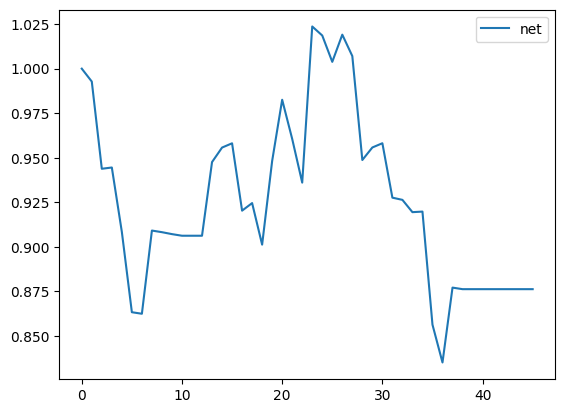

In [46]:
#initialize array
gross_returns = np.array([])
net_returns = np.array([])
t_s = np.array([])

stock1 = stocks[0]
stock2 = stocks[1]

#moving through sample
for t in range(window,len(data)):
    #define the unit root function: stock2 = a+b*stock1
    def unit_root(b):
        a = np.average(data[stock2][t-window:t] - b*data[stock1][t-window:t])
        fair_value = a + b*data[stock1][t-window:t]
        diff = np.array(fair_value - data[stock2][t-window:t])
        diff_diff = diff[1:] - diff[:-1]

        reg = sm.OLS(diff_diff, diff[:-1])
        res= reg.fit()
        return res.params[0]/res.bse[0]
    
    res1 = spop.minimize(unit_root, data[stock2][t]/data[stock1][t], method='Nelder-Mead')
    t_opt = res1.fun
    b_opt = float(res1.x)
    a_opt = np.average(data[stock2][t-window:t] - b_opt*data[stock1][t-window:t])
    fair_value = a_opt + b_opt * data[stock1][t]

    #optimising the cointegration equation parameters
    if t == window:
        old_signal = 0
    if t_opt > t_threshold:
        signal = 0
        gross_return = 0
    else:
        signal = np.sign(fair_value - data[stock2][t])
        gross_return = signal*returns[stock2][t] - signal*returns[stock1][t]

    fees = fee*abs(signal - old_signal)
    net_return = gross_return - fees 
    gross_returns = np.append(gross_returns, gross_return)
    net_returns = np.append(net_returns,net_return)
    t_s = np.append(t_s, t_opt)

    cumulative_net_returns = np.cumprod(1 + net_returns)-1

    #simulating trading
    # print('day ' + str(data.index[t]))
    # print(signal)
    # print('')
    # if signal == 0:
    #     print("no trade")
    # elif signal == 1:
    #     print("long position on" + stock2+ "short position" +stock1)
    # else:
    #     print("short position on" + stock2+ "long position" +stock1)
    
    # print('gross daily return '+ str(round(gross_return*100, 2))+"%")
    # print('net daily return '+ str(round(net_return*100, 2))+"%")
    # print('cumulative net return '+ str(round(np.prod(1 + net_return)*100 - 100, 2))+"%")

    # print('')
    old_signal = signal

# plt.plot(np.append(1, np.cumprod(1+gross_return)), label="gross")
plt.plot(np.append(1, np.cumprod(1+net_returns)), label="net")

plt.legend()
plt.show()


